### Data downloaded from https://simplemaps.com/data/us-cities

In [92]:
import pandas as pd
import requests
import json 
import numpy as np
import matplotlib.pyplot as pl

In [226]:
import os
import pickle
import geopandas as gpd
from shapely.geometry import Polygon, Point

### Finding driving distance
We use Open Source Routing Machine (OSRM) api to calculate this. 

http://project-osrm.org/docs/v5.24.0/api/?language=Python#general-options

In [341]:
def distance_between(loc1,loc2):

    """
    input:
        loc1: source location (lat,long)
        loc2: destination location (lat,long)
    output:
        distance: road distance in Km
        duration: time in mins
    """

    r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{loc1[1]},{loc1[0]};{loc2[1]},{loc2[0]}?overview=false""")
    # print(r.content)
    try: 
        content = json.loads(r.content)['routes'][0]
    except: 
        print(r.content)
        return False
    distance,duration = content['distance'],content['duration']

    return distance/1000, duration/60


In [281]:
def get_city_data():
    final_file = 'cities_data/simplemaps_uscities_basicv1.76/uscitites_clean.csv'
    if os.path.isfile(final_file):
        with open(final_file,'rb') as f:
            data = pickle.load(f)
        return data
    
    file_name = 'cities_data/simplemaps_uscities_basicv1.76/uscities.csv'
    city_data = pd.read_csv(file_name)
    required_cols = ['city','state_id','state_name','county_name','lat','lng','population','density']
    city_data_filtered = city_data.filter(required_cols,axis=1)
    with open(final_file,'wb') as f:
        pickle.dump(city_data_filtered,f)
    return city_data_filtered

In [282]:
city_data = get_city_data()

In [283]:
city_data.head()

,city,state_id,state_name,county_name,lat,lng,population,density
0,New York,NY,New York,Queens,40.6943,-73.9249,18972871,10768.2
1,Los Angeles,CA,California,Los Angeles,34.1141,-118.4068,12121244,3267.6
2,Chicago,IL,Illinois,Cook,41.8375,-87.6866,8595181,4576.6
3,Miami,FL,Florida,Miami-Dade,25.7840,-80.2101,5711945,4945.7
4,Dallas,TX,Texas,Dallas,32.7935,-96.7667,5668165,1522.2


In [285]:
loc1= (city_data.loc[city_data['city']=="Santa Barbara"][['lat','lng']]).values[0]
loc2 = (city_data.loc[city_data['city']=="Burbank"][['lat','lng']]).values[0]
print(loc1,loc2)
distance_between(loc1,loc2)

[  34.4285 -119.7202] [  34.1879 -118.3235]


(146.6678, 109.50333333333333)

### US state grid

In [269]:

def state_polygon(state_name):
    """Returns Polygon of a US state

    Args:
        state_name (str): US state name

    Returns:
        polygon: Polygon for the state boundary
    """
    boundaries = pd.read_csv('cities_data/us-state-boundaries.csv',sep=';')
    assert state_name in boundaries['name'].values, "State not in the list"
    
    boundaries = boundaries.filter(['name','St Asgeojson'],axis=1)
    state = json.loads((boundaries.loc[boundaries['name']==state_name]).values[0][1])
    polygon = Polygon(state['coordinates'][0][0])
    return polygon

def state_grid(state_name,resolution):
    """creates grid of points inside the state

    Args:
        state_name (str): name of the US state
        resolution (float): distance resolution for the grid (units of km)
    output:
        valid_points: list of (latitude,longitude) of points inside the state
    """

    polygon = state_polygon(state_name)
    

    ## Creating grid points inside the state
    x_min,y_min,x_max,y_max = polygon.bounds
    lat_dist_per_degree = 111 #in km
    long_dist_per_degree = np.cos((y_min+y_max)*0.5)*111 #km
    resolution_lat = resolution/lat_dist_per_degree
    resolution_long = resolution/long_dist_per_degree
    gridx_points = np.arange(x_min,x_max,resolution_long)
    gridy_points = np.arange(y_min,y_max,resolution_lat)
    # print(grid_points[0].flatten(),grid_points[1].flatten())
    valid_points = []
    invalid_points = []
    for x in gridx_points:
        for y in gridy_points:
            # print(Point(x,y).within(polygon))
            if Point(x,y).within(polygon):
                valid_points.append((x,y))
            else:
                invalid_points.append((x,y))
    return valid_points, polygon

In [270]:
CA_grid, CA_polygon = state_grid('California',25)

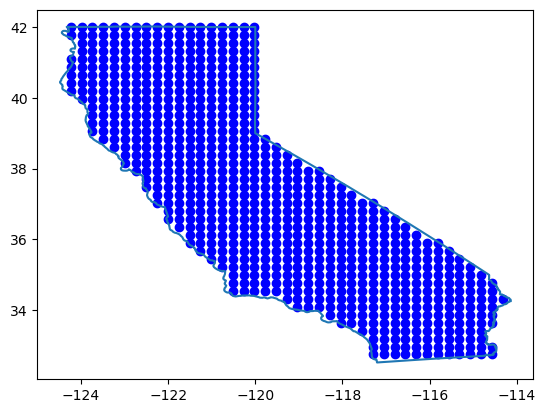

In [271]:
colors = ['blue','red']
pl.plot(*CA_polygon.exterior.xy)
[pl.scatter(*p,color='blue') for p in CA_grid]
# [pl.scatter(*p,color='red') for p in invalid_points]



In [273]:
len(CA_grid) #total number of grid points

776

## Driving distance to cities

In [286]:
locations = CA_grid.copy() # change this to change the dataset
state_name = 'California' # state to focus on

In [354]:
locations[1]

(-124.23422746313148, 40.41171488308802)

In [333]:
cities = (city_data[city_data['state_name']==state_name].reset_index(drop=True)).copy(deep=True)
cities.sort_values(by='population',ascending=False,inplace=True)
population_threshold = 80000
cities = cities.loc[cities['population']>population_threshold]

In [385]:
cities

,city,state_id,state_name,county_name,lat,lng,population,density
0,Los Angeles,CA,California,Los Angeles,34.1141,-118.4068,12121244,3267.6
1,San Francisco,CA,California,San Francisco,37.7558,-122.4449,3290197,7199.4
2,San Diego,CA,California,San Diego,32.8313,-117.1222,3084174,1675.9
3,Riverside,CA,California,Riverside,33.9381,-117.3949,2022285,1557.0
4,Sacramento,CA,California,Sacramento,38.5677,-121.4685,1924167,1971.3
...,...,...,...,...,...,...,...,...
111,Redwood City,CA,California,San Mateo,37.5025,-122.2253,83905,1687.6
112,Alhambra,CA,California,Los Angeles,34.0840,-118.1355,83174,4275.8
113,Madera,CA,California,Madera,36.9630,-120.0778,82772,1536.8
114,Lakewood,CA,California,Los Angeles,33.8471,-118.1222,82419,3272.3


In [387]:
def distance_from_cities(lat,lng,radii=None):
    """Generate driving distance of a point from major cities in a state

    Args:
        lat (float): latitude of the location 
        lng (float): longitude of the location
        radii (float, optional): Threshold for the distance in miles. Defaults to None.

    Returns:
        distance_list: distance of to all cities within the radii
        population_list: population of cities within the radii
    """
    distance_list = []
    population_list = []

    if radii is None:
        radii = 100000000 # some random value which is not possible in physical scenario
    lat_radii = radii/(111/1.6) # in miles
    lng_radii = abs(radii/(111*np.cos(lat)/1.6)) #in miles

    for index,city in cities.iterrows():
        city_lng,city_lat = city['lng'],city['lat']
        if abs(city_lng-lng) > lng_radii or abs(city_lat-lat) > lat_radii:
            continue
          
        dist = distance_between((lat,lng),(city_lat,city_lng))
        distance_list.append(dist)
        population_list.append(city['population'])
    return distance_list, population_list

In [389]:
dist_list, pop_list = distance_from_cities(locations[1][1],locations[1][0])


In [380]:
dist_list_100, pop_list_100 = distance_from_cities(locations[100][1],locations[100][0],radii=100)

In [390]:
len(dist_list_100), len(dist_list)

(36, 116)

In [399]:
# Generate a dataframe for a list of locations

radii = 100 #in mile
df = pd.DataFrame({'lng':[],'lat':[],'driving radii (in miles)':[],'number of cities':[],'total population':[]})
for loc in locations[100:101]:
    print(loc)
    # df['drivin radii'].append(radii)
    dist_list, pop_list = distance_from_cities(loc[1],loc[0],radii=radii)
    city_count = len(dist_list)
    population = np.sum(pop_list)
    print([loc[0],loc[1],radii,city_count,population])
    df = df.append({'lng':loc[0],'lat':loc[1],'driving radii (in miles)':radii,'number of cities':int(city_count),'total population':int(population)},ignore_index=True)

(-122.49979870421885, 37.709012180385336)
[-122.49979870421885, 37.709012180385336, 100, 36, 12563222]


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_9557/338677649.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'lng':loc[0],'lat':loc[1],'driving radii (in miles)':radii,'number of cities':int(city_count),'total population':int(population)},ignore_index=True)


In [400]:
df

,lng,lat,driving radii (in miles),number of cities,total population
0,-122.499799,37.709012,100.0,36.0,12563222.0
